# The Basic Model

## 1. Notations

- $n_s$ is the number of sites,
- $N_{ts}$ be the number of species at time $t$ and site $s$,
- $d_{si}$ be the distance between two sites $s$ and site $i$,
- The environmental variables are $e_{chi}, e_{sst}$ and $e_{upw}$,
- Let $y_{ts}=\log N_{(t+1)s}$.

## 2. The model

The raw model is:
$$
\begin{equation}
y=K\sum_{i=1}^{n_s}N_{ti}e^{-\frac{(d_{si}-\mu_d)^2}{\sigma_d^2}}+\beta_1e_{chi}+\beta_2e_{sst}+
\beta_3e_{upw}+\epsilon,
\end{equation}
$$

where $\epsilon\sim N(0,\sigma^2)$ .  So we have 

- three parameters related to the $\textbf{dispersal}$: $K, \mu_d, \sigma_d$.
- three parameters for the $\textbf{environmental}$ variables $\beta_1, \beta_2, \beta_3$.

## 3. Estimation

Let $\theta=(K, \mu_d, \sigma_d, \beta_1, \beta_2, \beta_3)$, $x$ be our data ($N$:number of species, $d$:distance between the sites, $e$: the environmentaall variables), $y=f(x,\theta)$ is our model. Then $y\sim N(f(x,\theta),\sigma^2)$

$$
\begin{equation}
L(\theta;y,x)=\prod_{j=1}^m \phi(\frac{y_j-f(x_j,\theta)}{\sigma})
\end{equation}
$$

and

$$
\begin{equation}
l(\theta;y,x)=\log L(\theta;y,x)=\sum_{j=1}^m \log \phi(\frac{y_j-f(x_j,\theta)}{\sigma})
\end{equation}
$$

**Note**: The model is a nonlinear regression problem. After some calculation about the above log-likelihood function, we can show that: maximum likelihood estimation is equivalent to the nonlinear least square estimation. So we need to minimize the objective function:

$$
\begin{equation}
\sum_{j=1}^n (y_j-f(x_j,\theta))^2
\end{equation}
$$

## 4. About the Data

As for our data, we have 4 years(year0, year1, year3, year4) data. So $y$ should be

$$
\begin{equation}
y=N_{ts}\quad for\quad [year1(s1,...,s48),year2(s1,...,s48),year3(s1,...,s48)]
\end{equation}
$$

Predictive variables $x$ contains three parts: 

1. species number $N$, 
$$
\begin{equation}
N=N_{ts}\quad for\quad [year0(s1,...,s48),year1(s1,...,s48),year2(s1,...,s48)]
\end{equation}
$$
2. the distance $d$, which should be a distance matrix between the sites (s1,...,s48)

3. the environmental variables $e_i$, which is
$$
\begin{equation}
e_i=e_{i}\quad for\quad [year0(s1,...,s48),year1(s1,...,s48),year2(s1,...,s48)]
\end{equation}
$$

## 5. Code and Results

### 5.0 EDA

In [1]:
library(synchrony)
data(pisco.data)
head(pisco.data)

synchrony 0.2.3 loaded.


,latitude,longitude,chl,sst,upwelling,mussel_abund,year
1,32.71167,-117.25,0.8897,16.51596,85.17711,1.0667,2000
2,32.82,-117.2767,0.8095,16.76317,85.17711,46.7,2000
3,32.84,-117.28,0.7844,16.78249,85.17711,10.6,2000
4,33.44,-118.4767,0.5192727,16.48601,70.71932,2.8,2000
5,33.45,-118.48,0.5192727,16.44148,70.71932,0.9333,2000
6,33.46,-118.52,0.5017273,16.44452,56.26153,0.4,2000


In the above data:

- lat and lon: the location of the stations(48 different stations)
- chl, sst, and upwelling: the environmental variables
- mussel_abund: the variable we want to predict
- year: 2000-2004

Now we extract the target variable, and the predictive variables:

In [20]:
summary(pisco.data)
#head(cbind(pisco.data[1:48,1],rep(pisco.data[1,2],48)))

    latitude       longitude           chl               sst        
 Min.   :32.71   Min.   :-124.7   Min.   : 0.4091   Min.   : 8.598  
 1st Qu.:34.36   1st Qu.:-124.1   1st Qu.: 1.2910   1st Qu.:10.899  
 Median :38.83   Median :-123.4   Median : 3.0401   Median :11.894  
 Mean   :39.55   Mean   :-122.1   Mean   : 4.2056   Mean   :12.643  
 3rd Qu.:44.37   3rd Qu.:-120.0   3rd Qu.: 7.0753   3rd Qu.:14.664  
 Max.   :48.39   Max.   :-117.2   Max.   :15.0320   Max.   :17.290  
   upwelling       mussel_abund         year     
 Min.   :-57.69   Min.   : 0.000   Min.   :2000  
 1st Qu.:-23.02   1st Qu.: 6.592   1st Qu.:2001  
 Median : 59.26   Median :24.817   Median :2002  
 Mean   : 37.82   Mean   :27.292   Mean   :2002  
 3rd Qu.: 84.36   3rd Qu.:44.008   3rd Qu.:2002  
 Max.   :120.82   Max.   :81.300   Max.   :2003  

In [38]:
y=subset(pisco.data,year>2000,select=c(mussel_abund)) # species number
y[y[,1]==0,]=min(y[y[,1]!=0,])/2 # replace 0 to the minimum positive number
y=log(y) # take log of the species number

N=subset(pisco.data,year<2003,select=c(mussel_abund)) # (past) species number
#D=coord2dist(pisco.data[1:48,1:2],lower.tri = F) # site distance
#D=coord2dist(cbind(pisco.data[1:48,1],rep(pisco.data[1,2],48)),lower.tri = F) # site distance
D=dist(pisco.data[1:48,1],diag = T,upper = T)
D=as.matrix(D)
for(i in 1:48){
    for(j in 1:48){
        if(i>j){
            D[i,j]=-D[i,j]
        }
    }
}
E=subset(pisco.data,year<2003,select=c(chl,sst,upwelling)) # Environment variable
D=as.matrix(D)
D[1:6,1:6]

,1,2,3,4,5,6
1,0.0000000,0.1083336,0.1283340,0.7283325,0.7383347,0.7483330
2,-0.10833359,0.00000000,0.02000046,0.61999893,0.63000107,0.63999939
3,-0.12833405,-0.02000046,0.00000000,0.59999847,0.61000061,0.61999893
4,-0.72833252,-0.61999893,-0.59999847,0.00000000,0.01000214,0.02000046
5,-0.738334656,-0.630001068,-0.610000610,-0.010002136,0.000000000,0.009998322
6,-0.748332977,-0.639999390,-0.619998932,-0.020000458,-0.009998322,0.000000000


Here, we define the objective function. Since we want to do minimization(not max), the objective function is the either the negative log-likelihood function, or the nonlinear least squre error(they are equivalent in our case). The input arguments are:

- t: all the parameters which need to do minimization, $(K, \mu_d, \sigma_d, \beta_1, \beta_2, \beta_3)$
- y: target variable(log of species number)
- N: past species number
- D: distance matrix among 48 sites
- E: 3 environmental variables

### 5.1 First model

$$
\begin{equation}
y=K\sum_{i=1}^{n_s}N_{ti}e^{-\frac{(d_{si}-\mu_d)^2}{\sigma_d^2}}+\beta_1e_{chi}+\beta_2e_{sst}+
\beta_3e_{upw}+\epsilon,
\end{equation}
$$

In [4]:
logl1=function(t,y,N,D,E){
  n=dim(y)[1]
  f=rep(0,n) # value of the regression function
  yr=rep(0:2,each=48) # 3 years(0-2) used: 00-03 for X, 01-04 for y
  for(j in 1:n){
    Ker=exp(-(D[j%%48+((j%%48)==0)*48,]-t[2])^2/(t[3]^2)) # dispersal kernal (for the 48 sites)
    Nj=N[(yr[j]*48+1):((yr[j]+1)*48),] # number of species for 48 sites
    f[j]=t[1]*sum(Ker*Nj)+t[4]*E[j,1]+t[5]*E[j,2]+t[6]*E[j,3] # dispersal + three environment terms
  }
  
  return(sum((y[,1]-f)^2)) # return the objective function
}

Now, we do the optimization with the **nlm** function in R.

In [5]:
t0=c(6,-0.2,0.5,0.1,0.1,0.006)
res1=nlm(logl1,t0,hessian=T,print.level=1,y=y,N=N,D=D,E=E,iterlim=1e4,steptol=1e-5)

iteration = 0
Step:
[1] 0 0 0 0 0 0
Parameter:
[1]  6.000 -0.200  0.500  0.100  0.100  0.006
Function Value
[1] 5219667
Gradient:
[1]  1751195.7 17853422.4  7915953.8   174597.8   535104.2  1614103.1

iteration = 22
Parameter:
[1]   3.643482425 -27.872366662 -13.264668303   0.072933308   0.004767965
[6]   0.010265979
Function Value
[1] 202.8531
Gradient:
[1] 0.208472743 0.146136428 0.128126871 0.001788550 0.005709296 0.038655003

Successive iterates within tolerance.
Current iterate is probably solution.



[1] "MSE in log scale is:  1.40870190009632"


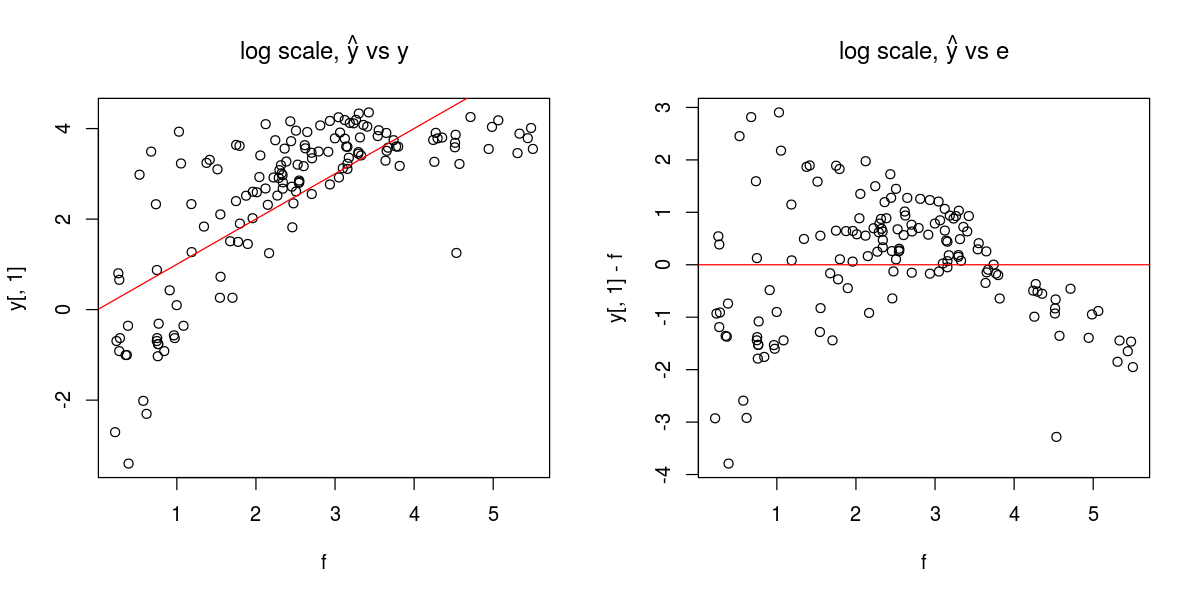

In [6]:
t=res1$estimate
n=dim(y)[1]
f=rep(0,n) # value of the regression function
yr=rep(0:2,each=48) # 3 years(0-2) used: 00-03 for X, 01-04 for y
for(j in 1:n){
Ker=exp(-(D[j%%48+((j%%48)==0)*48,]-t[2])^2/(t[3]^2)) # dispersal kernal (for the 48 sites)
Nj=N[(yr[j]*48+1):((yr[j]+1)*48),] # number of species for 48 sites
f[j]=t[1]*sum(Ker*Nj)+t[4]*E[j,1]+t[5]*E[j,2]+t[6]*E[j,3] # dispersal + three environment terms
}

MSE=mean((y[,1]-f)^2)
print(paste("MSE in log scale is: ",MSE))
par(mfrow=c(1,2))
options(repr.plot.width = 10)
options(repr.plot.height = 5)
plot(f,y[,1],main=expression(paste("log scale, ", hat(y)," vs y")))
abline(a=0,b=1,col=2)
plot(f,y[,1]-f,main=expression(paste("log scale, ", hat(y)," vs e")))
abline(a=0,b=0,col=2)

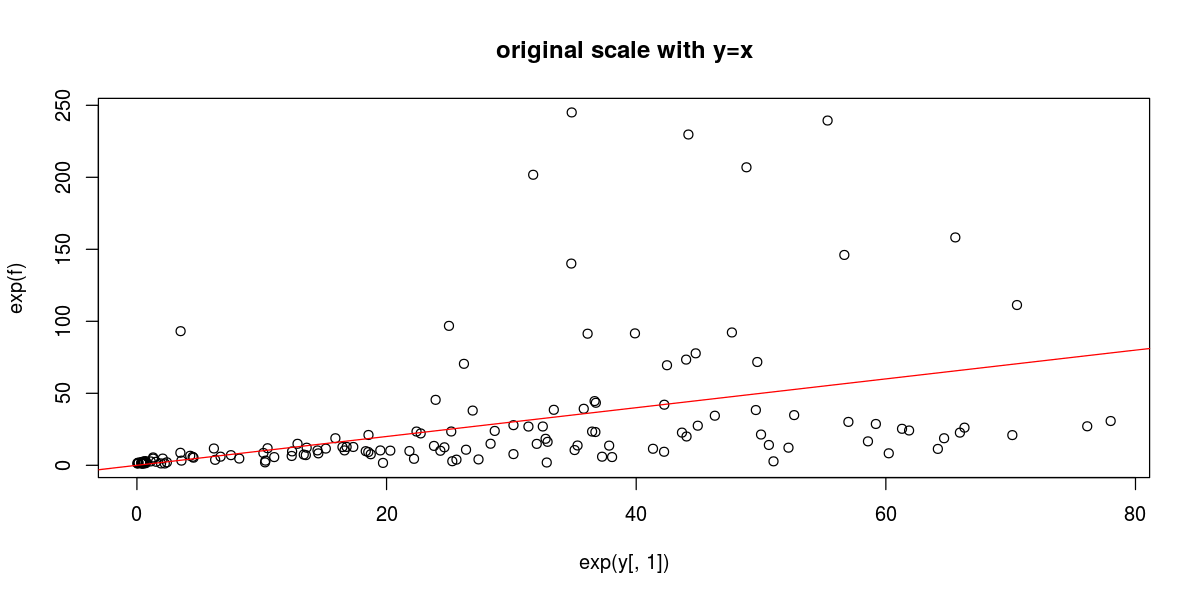

In [7]:
plot(exp(y[,1]),exp(f),main="original scale with y=x")
abline(a=0,b=1,col=2)

### 5.2 Second Model

$$
\begin{equation}
y=\log(e^K\sum_{i=1}^{n_s}N_{ti}e^{-\frac{(d_{si}-\mu_d)^2}{\sigma_d^2}})+\beta_1e_{chi}+\beta_2e_{sst}+
\beta_3e_{upw}+\epsilon,
\end{equation}
$$

$$
\begin{equation}
=K+\log(\sum_{i=1}^{n_s}N_{ti}e^{-\frac{(d_{si}-\mu_d)^2}{\sigma_d^2}})+\beta_1e_{chi}+\beta_2e_{sst}+
\beta_3e_{upw}+\epsilon,
\end{equation}
$$


In [39]:
# log-likelihood function
logl2=function(t,y,N,D,E){
  n=dim(y)[1]
  f=rep(0,n) # value of the regression function
  yr=rep(0:2,each=48) # 3 years(0-2) used: 00-03 for X, 01-04 for y
  for(j in 1:n){
    Ker=exp(-(D[j%%48+((j%%48)==0)*48,]-t[2])^2/(t[3]^2)) # dispersal kernal (for the 48 sites)
    Nj=N[(yr[j]*48+1):((yr[j]+1)*48),] # number of species for 48 sites
    f[j]=t[1]+log(sum(Ker*Nj))+t[4]*E[j,1]+t[5]*E[j,2]+t[6]*E[j,3] # dispersal + three environment terms
  }
  
  return(sum((y[,1]-f)^2)) # return the objective function
}


# do the optimization to find the parameters
t0=c(1,0,1,0.1,0.1,0.1)
res2=nlm(logl2,t0,hessian=T,print.level=1,y=y,N=N,D=D,E=E,iterlim=1e4,steptol=1e-5)

iteration = 0
Step:
[1] 0 0 0 0 0 0
Parameter:
[1] 1.0 0.0 1.0 0.1 0.1 0.1
Function Value
[1] 16552.29
Gradient:
[1]   2640.2677    223.2813   2436.9812   7644.3689  35891.0001 187877.4232

iteration = 61
Parameter:
[1]  1.0191051955 -0.0035246753 -0.0106411733  0.0001333653 -0.1045139552
[6]  0.0015669502
Function Value
[1] 106.6706
Gradient:
[1] -1.40124793  0.02515411  0.22112269  0.03462215  0.01106416 -0.54526949

Successive iterates within tolerance.
Current iterate is probably solution.



[1] "MSE in log scale is:  0.740768043728402"


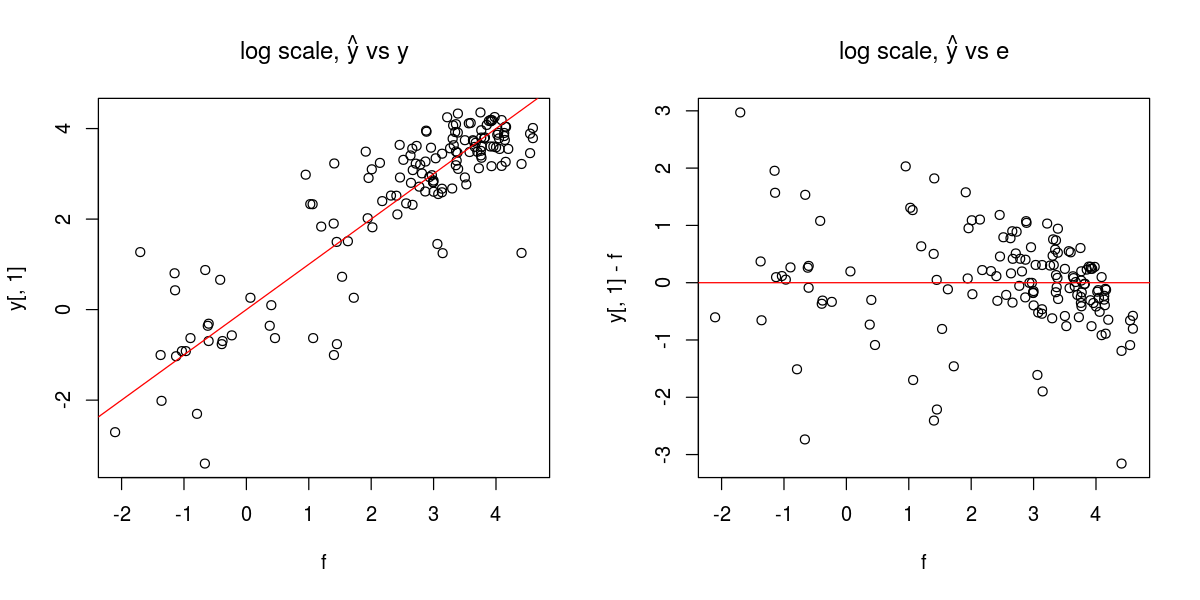

In [40]:
t=res2$estimate
n=dim(y)[1]
  f=rep(0,n) # value of the regression function
  yr=rep(0:2,each=48) # 3 years(0-2) used: 00-03 for X, 01-04 for y
  for(j in 1:n){
    Ker=exp(-(D[j%%48+((j%%48)==0)*48,]-t[2])^2/(t[3]^2)) # dispersal kernal (for the 48 sites)
    Nj=N[(yr[j]*48+1):((yr[j]+1)*48),] # number of species for 48 sites
    f[j]=t[1]+log(sum(Ker*Nj))+t[4]*E[j,1]+t[5]*E[j,2]+t[6]*E[j,3] # dispersal + three environment terms
  }
MSE=mean((y[,1]-f)^2)
print(paste("MSE in log scale is: ",MSE))
par(mfrow=c(1,2))
options(repr.plot.width = 10)
options(repr.plot.height = 5)
plot(f,y[,1],main=expression(paste("log scale, ", hat(y)," vs y")))
abline(a=0,b=1,col=2)
plot(f,y[,1]-f,main=expression(paste("log scale, ", hat(y)," vs e")))
abline(a=0,b=0,col=2)

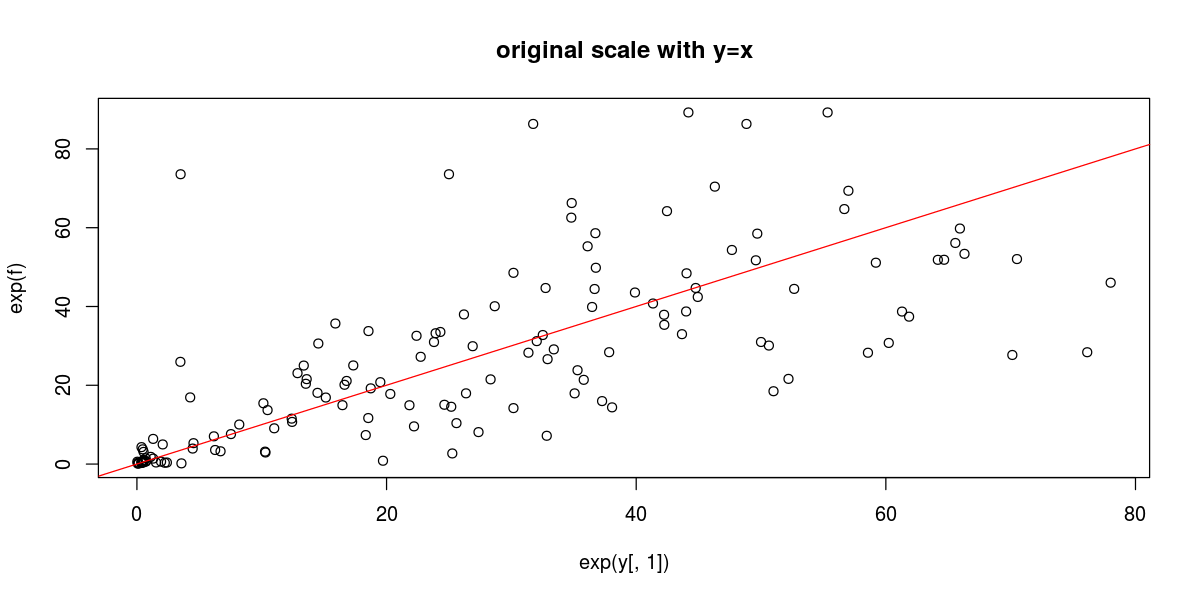

In [34]:
plot(exp(y[,1]),exp(f),main="original scale with y=x")
abline(a=0,b=1,col=2)

### 5.3 Third Model

$$
\begin{equation}
y=K+\log(\sum_{i=1}^{n_s}N_{ti}e^{-\frac{(d_{si}-\mu_d)^2}{\sigma_d^2}})+\beta_1e_{chi}+\beta_2e_{sst}+
\beta_3e_{upw}+\beta_4e_{chi}^2+\beta_5e_{sst}^2+
\beta_6e_{upw}^2+\epsilon,
\end{equation}
$$

In [22]:
# log-likelihood function
logl2=function(t,y,N,D,E){
  n=dim(y)[1]
  f=rep(0,n) # value of the regression function
  yr=rep(0:2,each=48) # 3 years(0-2) used: 00-03 for X, 01-04 for y
  for(j in 1:n){
    Ker=exp(-(D[j%%48+((j%%48)==0)*48,]-t[2])^2/(t[3]^2)) # dispersal kernal (for the 48 sites)
    Nj=N[(yr[j]*48+1):((yr[j]+1)*48),] # number of species for 48 sites
    f[j]=t[1]+log(sum(Ker*Nj))+t[4]*E[j,1]+t[5]*E[j,2]+t[6]*E[j,3]+t[7]*E[j,1]^2+t[8]*E[j,2]^2+t[9]*E[j,3]^2 # dispersal + three environment terms
  }
  
  return(sum((y[,1]-f)^2)) # return the objective function
}


# do the optimization to find the parameters
#t0=c(1,0,1,10,10,10,10,10,10)
t0=c(1,0,1,10,10,20,10,10,20)

res3=nlm(logl2,t0,hessian=T,print.level=1,y=y,N=N,D=D,E=E,iterlim=1e4,steptol=1e-5)

iteration = 0
Step:
[1] 0 0 0 0 0 0 0 0 0
Parameter:
[1]  1  0  1 10 10 20 10 10 20
Function Value
[1] 2.121983e+12
Gradient:
[1]     27490967      2236572      2876221     78246680    361068481
[6]   2072542773    374274292   4858331714 207288297925

iteration = 108
Parameter:
[1] -3.764524e-01 -1.572646e-01  1.641365e+00 -3.153264e-01  2.790607e-01
[6]  3.155909e-03  2.534358e-02 -1.604276e-02 -4.782614e-05
Function Value
[1] 92.96119
Gradient:
[1] -0.5955689821  0.9678708594 -0.1902599783 -0.0250303005  0.0851912259
[6] -0.0001412217  0.0011763940 -0.0041345336  0.0142553354

Successive iterates within tolerance.
Current iterate is probably solution.



[1] "MSE in log scale is:  0.645563788733292"


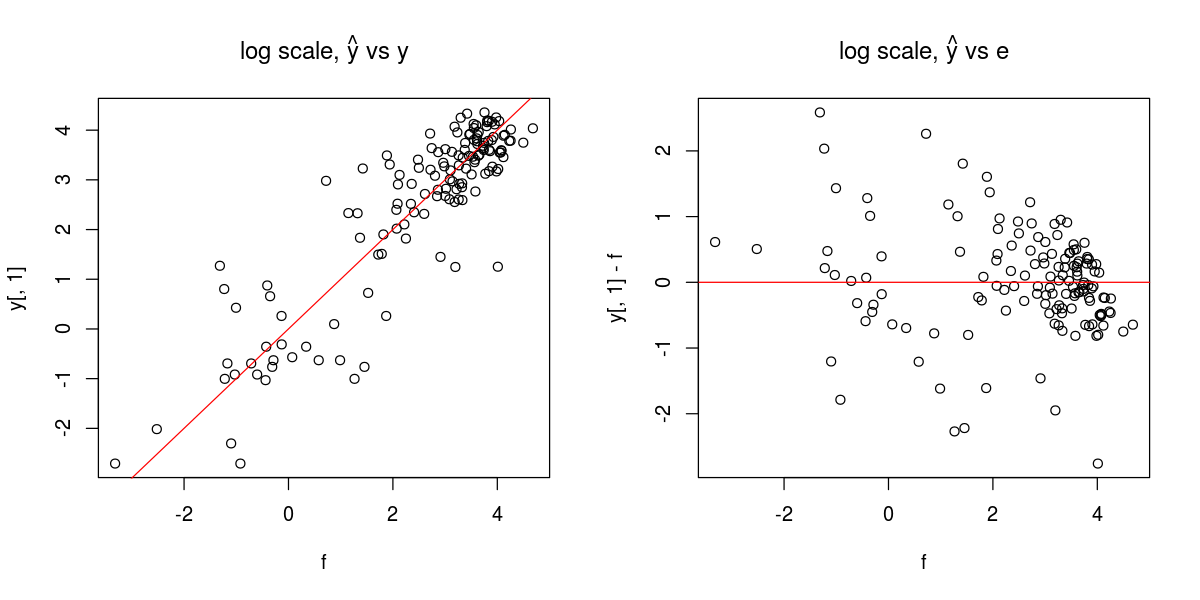

In [23]:
t=res3$estimate
n=dim(y)[1]
  f=rep(0,n) # value of the regression function
  yr=rep(0:2,each=48) # 3 years(0-2) used: 00-03 for X, 01-04 for y
  for(j in 1:n){
    Ker=exp(-(D[j%%48+((j%%48)==0)*48,]-t[2])^2/(t[3]^2)) # dispersal kernal (for the 48 sites)
    Nj=N[(yr[j]*48+1):((yr[j]+1)*48),] # number of species for 48 sites
    f[j]=t[1]+log(sum(Ker*Nj))+t[4]*E[j,1]+t[5]*E[j,2]+t[6]*E[j,3]+t[7]*E[j,1]^2+t[8]*E[j,2]^2+t[9]*E[j,3]^2 # dispersal + three environment terms
  }
MSE=mean((y[,1]-f)^2)
print(paste("MSE in log scale is: ",MSE))
par(mfrow=c(1,2))
options(repr.plot.width = 10)
options(repr.plot.height = 5)
plot(f,y[,1],main=expression(paste("log scale, ", hat(y)," vs y")))
abline(a=0,b=1,col=2)
plot(f,y[,1]-f,main=expression(paste("log scale, ", hat(y)," vs e")))
abline(a=0,b=0,col=2)

### 5.4 Fourth Model

$$
\begin{equation}
y=K+\log(\sum_{i=1}^{n_s}N_{ti}e^{-\frac{(d_{si}-\mu_d)^2}{\sigma_{di}^2}})+\beta_1e_{chi}+\beta_2e_{sst}+
\beta_3e_{upw}+\epsilon,
\end{equation}
$$

with $\theta=(\sigma_{d1},\cdots,\sigma_{d48}, \mu_d, K, \beta_1, \beta_2, \beta_3)$

In [ ]:
#y=subset(pisco.data,year>2000,select=c(mussel_abund)) # species number
#y[y[,1]==0,]=min(y[y[,1]!=0,])/2 # replace 0 to the minimum positive number

logl3=function(t,y,N,D,E){
  n=dim(y)[1]
  f=rep(0,n)
  yr=rep(0:2,each=48)
  for(j in 1:n){
    Ker=exp(-(D[j%%48+((j%%48)==0)*48,]-t[48+1])^2/(t[j%%48+((j%%48)==0)*48]^2)) # dispersal kernal 
    Nj=N[(yr[j]*48+1):((yr[j]+1)*48),]
    f[j]=t[48+2]+log(sum(Ker*Nj))+t[48+3]*E[j,1]+t[48+4]*E[j,2]+t[48+5]*E[j,3]
  }
  
  return(sum((y[,1]-f)^2))
}


t0=c(rep(1,48),0,0,0.1,0.1,0.1)
res3=nlm(logl3,t0,hessian=T,print.level=2,y=y,N=N,D=D,E=E,iterlim=1e4)

iteration = 0
Step:
 [1] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[39] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
Parameter:
 [1] 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
[20] 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
[39] 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.0 0.0 0.1 0.1 0.1
Function Value
[1] 9295.579
Gradient:
 [1]  0.000000e+00  6.738082e-01  2.008004e+01  1.509896e+01  4.806254e+01
 [6]  9.422365e-04  9.265841e-01  1.938701e+00  0.000000e+00  0.000000e+00
[11]  0.000000e+00  0.000000e+00  0.000000e+00  1.530225e+00  2.349709e+00
[16]  2.546585e-04  9.094947e-06  0.000000e+00  1.764420e-04  2.898378e-02
[21]  1.221815e-02  2.275315e+01  4.278795e+01  0.000000e+00  0.000000e+00
[26]  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
[31]  1.466966e+00  8.354857e+00 -6.198607e-01  7.164545e-01 -1.306507e-01
[36]  8.746429e-02  0.000000e+00 -4.609283e-01 -4.798949e-01 -9

Warning message:
In nlm(logl3, t0, hessian = T, print.level = 2, y = y, N = N, D = D, : NA/Inf replaced by maximum positive value

In [ ]:
t=res3$estimate

n=dim(y)[1]
  f=rep(0,n)
  yr=rep(0:2,each=48)
  for(j in 1:n){
    Ker=exp(-(D[j%%48+((j%%48)==0)*48,]-t[48+1])^2/(t[j%%48+((j%%48)==0)*48]^2)) # dispersal kernal 
    Nj=N[(yr[j]*48+1):((yr[j]+1)*48),]
    f[j]=t[48+2]+log(sum(Ker*Nj))+t[48+3]*E[j,1]+t[48+4]*E[j,2]+t[48+5]*E[j,3]
  }

# do the optimization to find the parameters
#t0=c(5,0,1,1,1,1)
#res=nlm(logl3,t0,hessian=T,print.level=1,y=y,N=N,D=D,E=E,iterlim=1e4,steptol=1e-5)
#t=res$estimate
# Calculate the predictive result
MSE=mean((y[,1]-f)^2)
print(MSE)
options(repr.plot.width = 5)
options(repr.plot.height = 5)
plot(y[,1],f,main="log scale with y=x")
abline(a=0,b=1,col=2)